# complex maps task
- named after complex span task
- trial consists of 3 phases
    - instruction phase, as dual PM task
    - OG phase, where the network knows to perform OG task
    - maps phase, where the network performs pure PM task


### in conversation with Ken:
- the only reason to use a dual PM is to keep WM busy with OG task
- mainly interested in development of buckets under EM strategy 

In [1]:
from glob import glob as glob
import itertools

import torch as tr
import numpy as np

from PM_models import *
from PM_tasks import *
from helperfuns_dualPM import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


# load net, eval, save evalacc

In [2]:
BEGIN_MAPS_TASK = BEGIN_MAPS = 8

def load_net(nback,nmaps,seed):
  net = NetDualPM(stsize=20,seed=seed)
  fpath = 'model_data/complex_maps_sweep2/'
  fpath += "LSTM20-EM1-nback_%i-num_maps_%i-num_trials_3-trial_len_16-seed_%i-model.pt"%(nback,nmaps,seed)
  net.load_state_dict(tr.load(fpath))
  net.seed = seed
  net.nback = nback
  net.nmaps = nmaps
  return net

def load_netL(nback,nmaps,num_subs=20):
  netL = []
  for seed in range(num_subs):
    try:
      net = load_net(nback,nmaps,seed)
      netL.append(net)
    except:
      pass
  print('N =',len(netL))
  return netL

### eval and save eval acc

N = 20


In [6]:
EV_NTRIALS = 1
EV_TRLEN = 20
EV_NEPS = 500

nbackL,nmapsL = [1,2,3],[3,4,5,8]
for nback,nmaps in itertools.product(nbackL,nmapsL):
  print(nback,nmaps)
  netL = load_netL(nback,nmaps,num_subs=20)
  gen_data_fn = lambda : task.gen_ep_data(
                          num_trials=EV_NTRIALS,
                          trial_len=EV_TRLEN,
                          pm_probe_positions=np.arange(BEGIN_MAPS,EV_TRLEN))

  ''' eval with lessions '''
  for net in netL:
    task = TaskDualPM(num_back=net.nback,pm_maps=net.nmaps,seed=net.seed)
    accL = []
    for wm,em in zip([1,1,0],[1,0,1]):
      net.EMsetting=em
      net.WMsetting=wm
      acc = eval_net(net,task,neps=EV_NEPS,gen_data_fn=gen_data_fn,return_states=False)
      accL.append(acc)
    acc = np.stack(accL) # full,em=0,wm=0
    fpath = "model_data/complex_maps_sweep2/eval_data/"
    fpath += "nback_%i-nmaps_%i-seed_%i-evacc"%(net.nback,net.nmaps,net.seed)
    np.save(fpath,acc)


1 3
N = 20
1 4
N = 20
1 5
N = 20
1 8
N = 20
2 3
N = 20
2 4
N = 20
2 5
N = 20
2 8
N = 20
3 3
N = 20
3 4
N = 20
3 5
N = 20
3 8
N = 20


### plot eval acc per subject for different lessions

In [168]:
def plt_accarr(ax,accarr):
  ax.set_ylim(0,1.05)
  cL = ['g','purple','red']
  for idx,acc in enumerate(accarr):
    ax.plot(acc,c=cL[idx],lw=3)
    

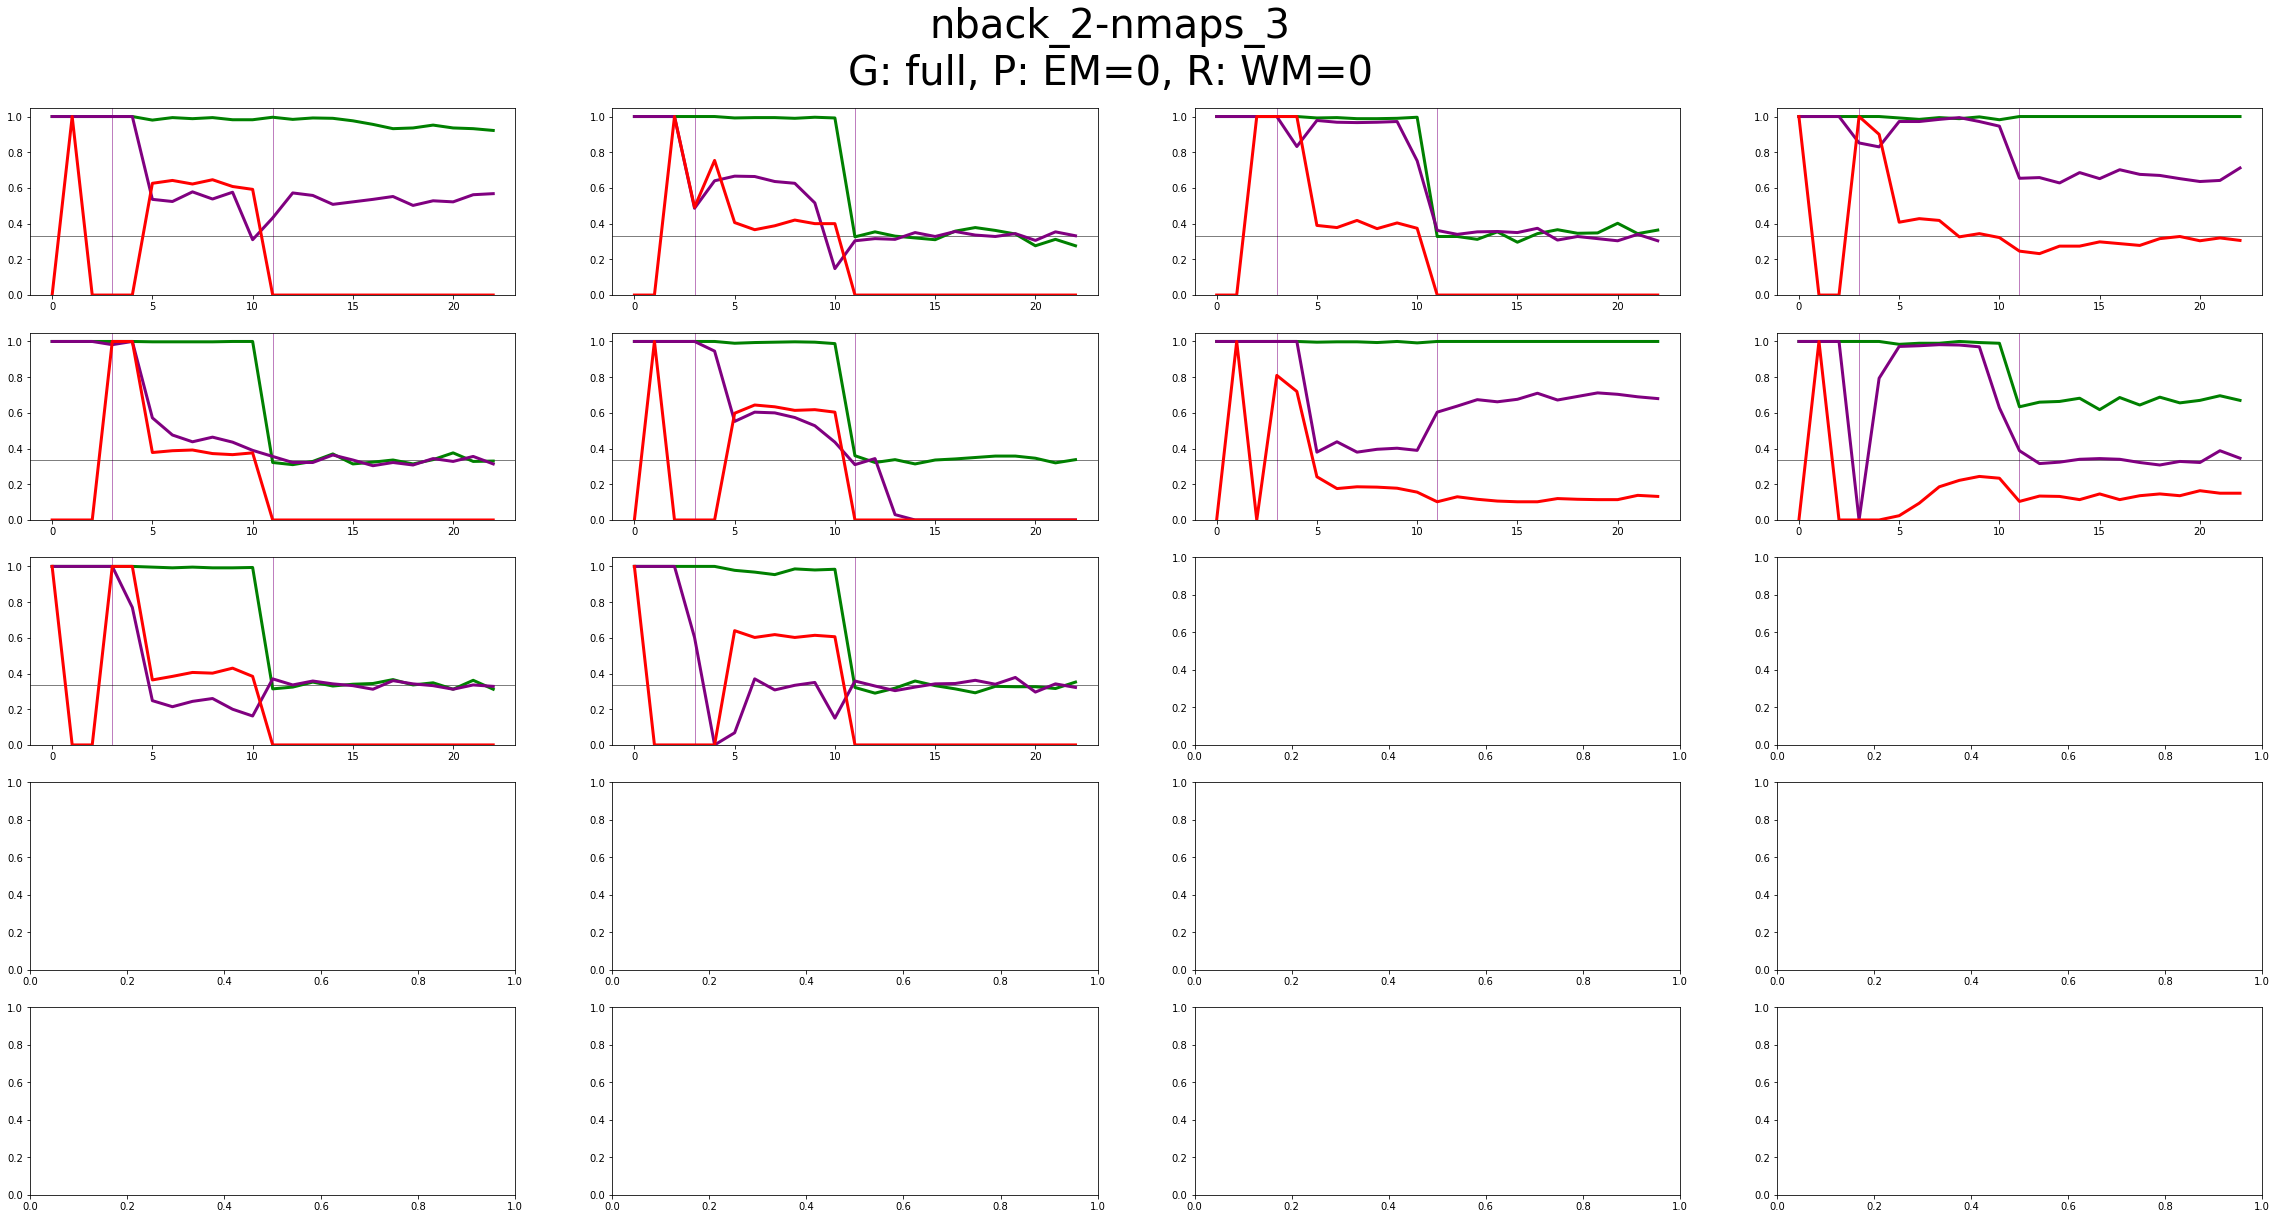

In [171]:
nback,nmaps = 2,3
exp_len = EV_NTRIALS*(EV_TRLEN+nmaps)
fig,axarr = plt.subplots(5,4,figsize=(40,20));axarr=axarr.reshape(-1)
for seed in range(10):
  ax = axarr[seed]
  ax.axvline(nmaps+BEGIN_MAPS_TASK,c='purple',lw=.5)
  ax.axvline(nmaps,c='purple',lw=.5)
  ax.axhline(1/nmaps,c='k',lw=.5)
  ## load data
  fpath = "model_data/complex_maps_sweep2/eval_data/"
  fpath += "nback_%i-nmaps_%i-seed_%i-evacc.npy"%(nback,nmaps,seed)
  accarr = np.load(fpath) #[full,em=0,wm=0]
  plt_accarr(ax,accarr)
  
title = 'nback_%i-nmaps_%i'%(nback,nmaps)
plt.suptitle(title + "\nG: full, P: EM=0, R: WM=0",y=.95,fontsize=40)
plt.savefig('figures/complex_maps_sweep2/'+title)

# train and eval 

### init

In [26]:
# task sweep params
num_back = 1
pm_maps = 3 # number of maps active per trial
seed = 6
EMsetting = 1
## initialize
task = TaskDualPM(num_back=num_back,pm_maps=pm_maps,seed=seed)
net = NetDualPM(stsize=20,emsetting=EMsetting,seed=seed)

### train

In [27]:
## similar to a complex span task
gen_data_fn = lambda : task.gen_ep_data(num_trials=4,trial_len=10,pm_probe_positions=np.arange(5,10))
tr_acc = train_net(net,task,neps=100000,gen_data_fn=gen_data_fn,verb=True)

0.0 117.90936
0.2 23.37103
0.4 21.916426
0.6 24.321117
0.8 28.606827


(0, 1)

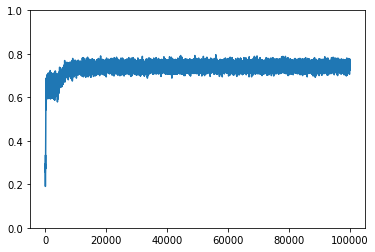

In [28]:
plt.plot(mov_avg(tr_acc,10))
plt.ylim(0,1)

### eval

In [11]:
gen_data_fn = lambda : task.gen_ep_data(num_trials=4,trial_len=7,pm_probe_positions=np.arange(5,7))
net.EMsetting=1
evacc = eval_net2(net,task,1000,gen_data_fn)

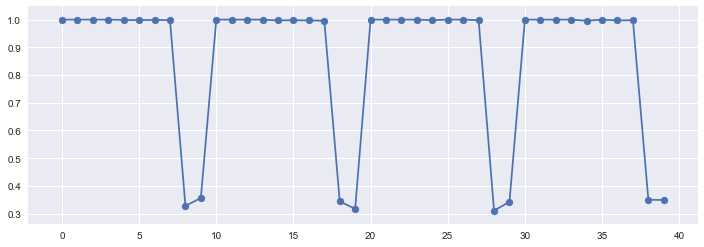

In [12]:
plt.figure(figsize=(12,4))
plt.plot(evacc)
plt.scatter(range(len(evacc)),evacc)
